#Before we start 

This notebook was created using Google Colab, with Version 5.10.147+ of the platform and Python Version 3.9.16. Any additional packages installed in this notebook are compatible with these versions.

In [ ]:
pip install geopandas 

In [ ]:
pip install contextily

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import requests
import os
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

#Task 1: Data Download

Bonus 1: Allow different values to be passed as parameters through command line interface when running the script.

Note : The parameter selected for this run is agency = 'HPD'.

In [43]:
from datetime import datetime
# Get agency value from user input
agency = input("Enter agency value: ")

# Set API endpoint URL
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

# Set query parameters
query_params = {
    # "$limit": 5000,
    "$where": "created_date >= '{}' and agency = '{}'".format((datetime.now() - timedelta(days=7)).strftime('%Y-%m-%dT%H:%M:%S'), agency)
}

# Make API request
response = requests.get(url, params=query_params)

# Convert JSON response to pandas DataFrame
df = pd.read_json(response.text)

# Create 'data' folder if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

Enter agency value: HPD


Store dataframe to 'data' folder.

In [44]:
df.to_csv("data/raw.csv", index=False)

A quick loof of raw.csv: 

In [45]:
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,closed_date
0,57210078,2023-04-02T23:58:19.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,11226,89 CROOKE AVENUE,CROOKE AVENUE,...,BROOKLYN,994582,177084,ONLINE,Unspecified,BROOKLYN,40.652725,-73.962765,"{'latitude': '40.65272532290535', 'longitude':...",NaN
1,57209525,2023-04-02T23:51:46.000,HPD,Department of Housing Preservation and Develop...,PLUMBING,BATHTUB/SHOWER,RESIDENTIAL BUILDING,10458,558 EAST 191 STREET,EAST 191 STREET,...,BRONX,1015845,252477,ONLINE,Unspecified,BRONX,40.859609,-73.885781,"{'latitude': '40.85960927766253', 'longitude':...",NaN
2,57207727,2023-04-02T23:51:46.000,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,PESTS,RESIDENTIAL BUILDING,10458,558 EAST 191 STREET,EAST 191 STREET,...,BRONX,1015845,252477,ONLINE,Unspecified,BRONX,40.859609,-73.885781,"{'latitude': '40.85960927766253', 'longitude':...",NaN
3,57212087,2023-04-02T23:51:46.000,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,PESTS,RESIDENTIAL BUILDING,10458,558 EAST 191 STREET,EAST 191 STREET,...,BRONX,1015845,252477,ONLINE,Unspecified,BRONX,40.859609,-73.885781,"{'latitude': '40.85960927766253', 'longitude':...",NaN
4,57211360,2023-04-02T23:51:46.000,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,MOLD,RESIDENTIAL BUILDING,10458,558 EAST 191 STREET,EAST 191 STREET,...,BRONX,1015845,252477,ONLINE,Unspecified,BRONX,40.859609,-73.885781,"{'latitude': '40.85960927766253', 'longitude':...",NaN


#Task 2: Data Aggregation via Python

In [46]:
# Read CSV file into pandas DataFrame
df = pd.read_csv("data/raw.csv")

# Convert created_date column to datetime
df['created_date'] = pd.to_datetime(df['created_date'])

# Create new columns for date and hour
df['created_date_hour'] = df['created_date'].dt.floor('h')
df['complaint_type'] = df['complaint_type'].str.strip()

# Group by created_date_hour and complaint_type, and count the number of complaints
ts_df = df.groupby(['created_date_hour', 'complaint_type']).size().reset_index(name='count')

Store dataframe to 'data' folder.

In [47]:
ts_df.to_csv("data/time_series.csv", index=False)

A quick loof of time_series.csv: 

In [48]:
ts_df.head()

,created_date_hour,complaint_type,count
0,2023-04-02 06:00:00,DOOR/WINDOW,1
1,2023-04-02 06:00:00,HEAT/HOT WATER,3
2,2023-04-02 06:00:00,UNSANITARY CONDITION,1
3,2023-04-02 07:00:00,GENERAL,1
4,2023-04-02 07:00:00,HEAT/HOT WATER,31


#Task 3: Data Visualization via Python

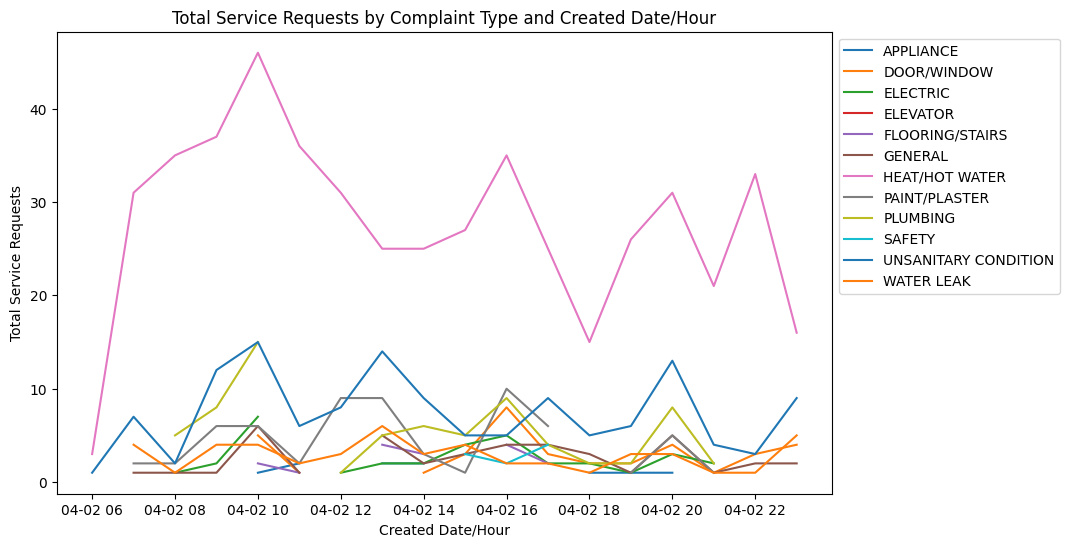

In [49]:
# Convert created_date_hour column to datetime
ts_df['created_date_hour'] = pd.to_datetime(ts_df['created_date_hour'])

# Pivot DataFrame to wide format
pivot_df = ts_df.pivot(index='created_date_hour', columns='complaint_type', values='count')

# Create multi-line plot
plt.figure(figsize=(10, 6))
plt.title("Total Service Requests by Complaint Type and Created Date/Hour")
plt.xlabel("Created Date/Hour")
plt.ylabel("Total Service Requests")
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

Store this image to 'data' folder as a .png file.

In [50]:
plt.savefig("data/service_requests.png")

<Figure size 640x480 with 0 Axes>

#Task4 : Spatial data processing via Python

Requst 2020 NTA (Neighborhood Tabulation Area) boundaries

In [51]:
url = "https://data.cityofnewyork.us/api/geospatial/a9we-mtpn?method=export&format=GeoJSON"

# Make HTTP request
response = requests.get(url)

# Save GeoJSON file to 'data' folder
with open("data/nta.geojson", "wb") as f:
    f.write(response.content)

Read GeoJSON file into geopandas DataFrame.


In [52]:
nta_gdf = gpd.read_file("data/nta.geojson")

Perform spatial data processing.

Note : The parameter selected for this run is complaint_type = 'appliance'.

Enter complaint_type value: appliance


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


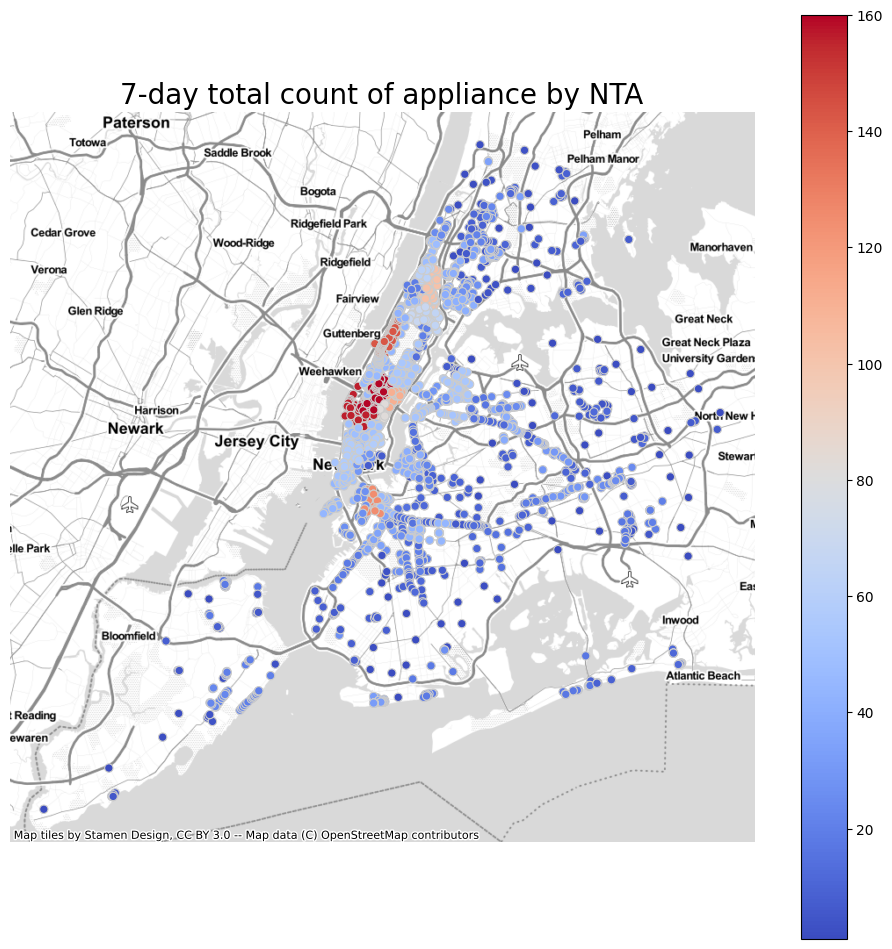

In [53]:
import datetime
# Filter the dataset for 'Electric' complaint_type and 7-day time window

complaint_type = input("Enter complaint_type value: ")

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=7)

filtered_df = df[
    (df['complaint_type'] == complaint_type) &
    (df['created_date'] >= start_date) &
    (df['created_date'] <= end_date)
]

# Convert filtered DataFrame to GeoDataFrame and set the CRS
filtered_gdf = gpd.GeoDataFrame(
    filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude)
)
filtered_gdf.crs = nta_gdf.crs

# Perform the spatial merge
merged_gdf = gpd.sjoin(nta_gdf, filtered_gdf, how='left', op='intersects')

# Aggregate counts by NTA
incident_counts = merged_gdf.groupby('ntacode').size().reset_index(name='count')

# Merge the counts back to the NTA dataset
nta_with_counts = nta_gdf.merge(incident_counts, on='ntacode', how='left').fillna(0)

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
nta_with_counts_web_mercator = nta_with_counts.to_crs(epsg=3857)

# Create the choropleth map
fig, ax = plt.subplots(1, figsize=(12, 12))
nta_with_counts_web_mercator.plot(column='count', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Remove the axis
ax.axis('off')

# Set the title
ax.set_title('7-day total count of {} by NTA'.format(complaint_type), fontdict={'fontsize': '20', 'fontweight': '3'})
plt.show()
